In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [5]:
df = pd.read_csv('../../fall_pose_keypoint_v2.csv')
df.head()

,image_name,label,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,poepoes (7).jpg,needhelp,0.802498,0.561774,0.813926,0.562861,0.819918,0.544108,0.814199,0.565528,...,0.518126,0.496779,0.384694,0.551551,0.379427,0.505839,0.234543,0.503823,0.221133,0.427620
1,people-1671-_jpg.rf.721c4272719dbac3265bbb8a7a...,needhelp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.049140,0.096838,0.036475,0.216825,0.056460,0.221321,0.051879,0.373114,0.061669,0.382340
2,people-1671-_jpg.rf.721c4272719dbac3265bbb8a7a...,needhelp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.236854,0.078964,0.199388,0.161084,0.247893,0.161160,0.164344,0.252980,0.273755,0.252240
3,people-1671-_jpg.rf.721c4272719dbac3265bbb8a7a...,needhelp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.981390,0.259671,0.982661,0.260302,0.947703,0.360081,0.953294,0.361626
4,people-1671-_jpg.rf.721c4272719dbac3265bbb8a7a...,needhelp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797548,0.024245,0.820755,0.100652,0.795297,0.101185,0.804242,0.171119,0.787399,0.173734


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_name        455 non-null    object 
 1   label             455 non-null    object 
 2   nose_x            455 non-null    float64
 3   nose_y            455 non-null    float64
 4   left_eye_x        455 non-null    float64
 5   left_eye_y        455 non-null    float64
 6   right_eye_x       455 non-null    float64
 7   right_eye_y       455 non-null    float64
 8   left_ear_x        455 non-null    float64
 9   left_ear_y        455 non-null    float64
 10  right_ear_x       455 non-null    float64
 11  right_ear_y       455 non-null    float64
 12  left_shoulder_x   455 non-null    float64
 13  left_shoulder_y   455 non-null    float64
 14  right_shoulder_x  455 non-null    float64
 15  right_shoulder_y  455 non-null    float64
 16  left_elbow_x      455 non-null    float64
 1

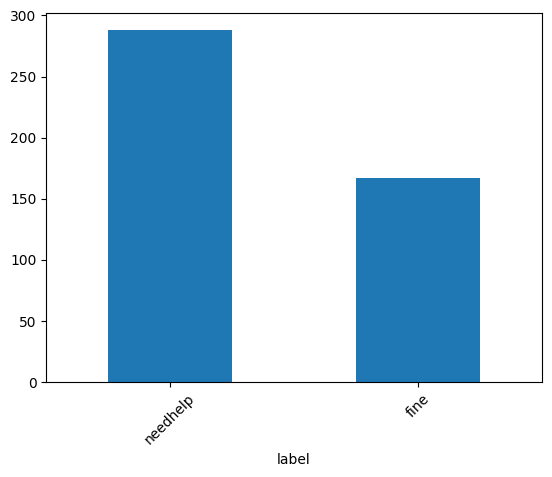

In [7]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

In [8]:
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

array([1.36227545, 0.78993056])

In [10]:
X = df.iloc[:,12:]
X

,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.737621,0.603241,0.748894,0.569644,0.667450,0.695868,0.660114,0.690150,0.596473,0.810467,...,0.518126,0.496779,0.384694,0.551551,0.379427,0.505839,0.234543,0.503823,0.221133,0.427620
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084541,0.045062,0.000000,0.000000,...,0.049140,0.096838,0.036475,0.216825,0.056460,0.221321,0.051879,0.373114,0.061669,0.382340
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.171284,0.021137,0.000000,0.000000,...,0.236854,0.078964,0.199388,0.161084,0.247893,0.161160,0.164344,0.252980,0.273755,0.252240
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.981390,0.259671,0.982661,0.260302,0.947703,0.360081,0.953294,0.361626
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797548,0.024245,0.820755,0.100652,0.795297,0.101185,0.804242,0.171119,0.787399,0.173734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.594235,0.659185,0.505238,0.649343,0.668350,0.708480,0.474453,0.745726,0.779290,0.725125,...,0.523627,0.802135,0.625487,0.846450,0.604611,0.841912,0.683063,0.938181,0.694631,0.936143
451,0.496982,0.236859,0.407661,0.222786,0.488561,0.340682,0.380669,0.308000,0.449925,0.371222,...,0.496603,0.289264,0.508971,0.421559,0.469300,0.413817,0.510707,0.582183,0.497219,0.574109
452,0.261371,0.413688,0.461764,0.422827,0.252134,0.595633,0.501921,0.617160,0.307776,0.714301,...,0.503409,0.648947,0.601380,0.675591,0.696195,0.684788,0.846905,0.690198,0.849311,0.694144
453,0.313163,0.484568,0.137242,0.555459,0.397813,0.564712,0.141219,0.681107,0.322517,0.656164,...,0.433086,0.663004,0.765346,0.540039,0.704348,0.599524,0.882335,0.558184,0.876478,0.591071


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2022)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_val))

Number of Training keypoints:  364
Number of Testing keypoints:  91


In [12]:
scaler = MinMaxScaler()

In [13]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_val)
X_test

array([[0.21089646, 0.73605159, 0.20885267, ..., 0.76751035, 0.84299006,
        0.77841611],
       [0.84429365, 0.91318913, 0.36132634, ..., 0.        , 0.        ,
        0.        ],
       [0.66627073, 0.94070668, 0.23023562, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.64260024, 0.25628811, 0.45901929, ..., 0.96515797, 0.47861468,
        0.9429611 ],
       [0.        , 0.        , 0.        , ..., 0.28139815, 0.82805958,
        0.27589744],
       [0.        , 0.        , 0.        , ..., 0.52185346, 0.95558333,
        0.51556384]])

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    return acc

In [20]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params

print(f"Best hyperparameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")

[I 2024-12-18 12:01:46,771] A new study created in memory with name: no-name-4a258b58-7283-46b3-b5b1-37d8d2336eac
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[I 2024-12-18 12:01:46,896] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 152, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 0 with value: 0.7692307692307693.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[I 2024-12-18 12:01:47,050] Trial 1 finished with value: 0.7802197802197802 and parameters: {'n_estimators': 181, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is

Best hyperparameters: {'n_estimators': 192, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Best accuracy: 0.8241758241758241


In [21]:
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, min_samples_leaf=4, n_estimators=192,
                       random_state=42)

In [22]:
y_pred = best_rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Final model accuracy: {accuracy}")

Final model accuracy: 0.8241758241758241


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [23]:
print(classification_report(y_val, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

        fine       0.87      0.61      0.71        33
    needhelp       0.81      0.95      0.87        58

    accuracy                           0.82        91
   macro avg       0.84      0.78      0.79        91
weighted avg       0.83      0.82      0.82        91



In [24]:
import joblib

PATH_SAVE = '../../../../../data/weights/yolo_pose_rfClassifier/pose_classification_v1.pkl'

joblib.dump(best_rf_model, PATH_SAVE)

['../../../../../data/weights/yolo_pose_rfClassifier/pose_classification_v1.pkl']